In [2]:
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
!unzip -o -d ./images MP6843_img_full.zip
!unzip -o -d ./labels MP6843_seg.zip
!rm *.zip

--2021-08-03 07:57:01--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240194618 (229M) [application/zip]
Saving to: ‘MP6843_img_full.zip’

MP6843_img_full.zip 100%[===================>] 229.07M  2.54MB/s    in 80s     

2021-08-03 07:58:21 (2.87 MB/s) - ‘MP6843_img_full.zip’ saved [240194618/240194618]

--2021-08-03 07:58:21--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, aw

In [3]:
import numpy as np
from os import listdir
from os.path import join
import cv2

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
num_classes = 2
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [5]:
im_root, lb_root = "./images", "./labels"
im_files = [join(im_root, im) for im in sorted(listdir(im_root)) if 'w1' in im]
lb_files = [join(lb_root, lb) for lb in sorted(listdir(lb_root)) if '_01' in lb]

In [6]:
dim = (696, 520)
images = np.array([cv2.resize(cv2.imread(img), dim, interpolation = cv2.INTER_AREA) for img in im_files])
labels = np.array([cv2.imread(lbl, 0) for lbl in lb_files]) / 255

In [51]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(256),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.transform(self.labels[ind])

        return img, lbl

In [91]:
lb_files[2]

'./labels/F01_1377_GT_01.tif'

In [7]:
array = labels[2]
x, y = np.where(array > 0.5)

cells = list(zip(x, y))
instance = np.zeros_like(array)
current_inst = 1

def recurt(x, y, current_inst):
    instance[x, y] = current_inst
    array[x, y] = 0
    for (xc, yc) in frien:
        instance[xc, yc] = instance[x, y]
        recurt(xc, yc, current_inst)
    current_inst += 1
    return current_inst

for idx, coord in enumerate(cells):
    col, row = coord
    if idx == 3:
        # Indices of neighbouring pixels 
        x1 = (col - 1) if col > 0 else col
        x2 = (col + 1) if col <= len(cells) else col
        y1 = (row - 1) if row > 0 else row
        y2 = (row + 1) if row <= len(cells) else row

        neigh = [(c, r) for c in range(x1, x2+1) for r in range(y1, y2+1)]
        frien = [t for t in neigh if array[t] > 0.5 and t != (col, row)]

        current_inst = recurt(col, row, current_inst)
    
print(np.unique(instance))
print(current_inst)

RecursionError: ignored

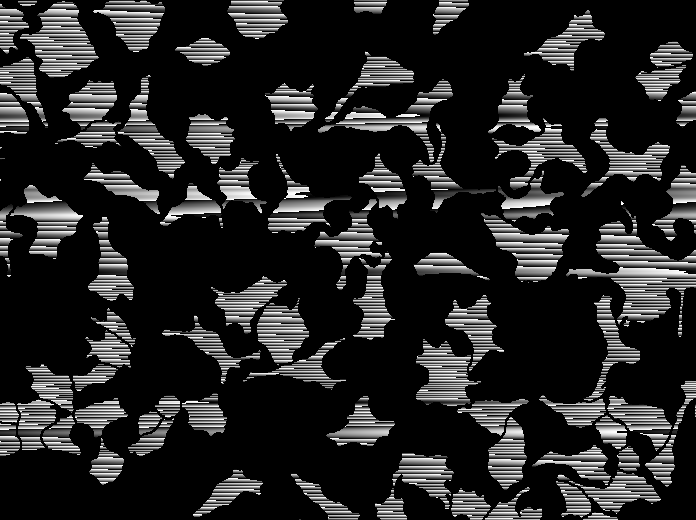

In [186]:
from PIL import Image
Image.fromarray(np.uint8(instance))

In [ ]:
with np.printoptions(threshold=np.inf):
    print(cells[0])

(array([  0,   0,   0, ..., 519, 519, 519]), array([ 18,  19,  20, ..., 615, 616, 617]))
((array([  0,   0,   0, ..., 519, 519, 519]),), (array([ 18,  19,  20, ..., 615, 616, 617]),))
